### set folder_name and day session to analyze

In [36]:
name = 'ANM5'
session = '20240212_d1'

### imports

In [37]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [38]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscriminationData/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, arduino, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

respMTX shape: (58, 7)
MTXTrialType shape: (1, 1)
number of trials: 58


In [39]:
open(leverdata_matfile)

<_io.TextIOWrapper name='../Data_Copy/LeverData/ANM5/LeverData_ANM5_20240212_d1.mat' mode='r' encoding='UTF-8'>

For mac:

In [40]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANM5/PreprocessLeverData_ANM5_20240212_d1/: File exists


For windows:

In [41]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANM5/PreprocessLeverData_ANM5_20240212_d1/: File exists


preview trials

In [42]:
respMTX.shape

(58, 7)

In [43]:
respMTX_shape = respMTX.shape[0]
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(np.hstack((respMTX[1:respMTX_shape, 1:2]-respMTX[0:respMTX_shape-1, 1:2], np.array([np.linspace(0, respMTX_shape-2, respMTX_shape-1)]).transpose())))

[[5.673604 0.000000]
 [25.227830 1.000000]
 [5.755553 2.000000]
 [7.391006 3.000000]
 [6.345269 4.000000]
 [13.599167 5.000000]
 [16.520498 6.000000]
 [6.017405 7.000000]
 [34.556688 8.000000]
 [35.393147 9.000000]
 [24.560262 10.000000]
 [6.815593 11.000000]
 [14.548424 12.000000]
 [6.106580 13.000000]
 [6.422878 14.000000]
 [6.355444 15.000000]
 [4.811069 16.000000]
 [17.998131 17.000000]
 [18.052752 18.000000]
 [6.902540 19.000000]
 [5.558875 20.000000]
 [6.269499 21.000000]
 [6.497890 22.000000]
 [7.037219 23.000000]
 [6.827862 24.000000]
 [22.536218 25.000000]
 [7.244517 26.000000]
 [6.003238 27.000000]
 [15.642252 28.000000]
 [7.497431 29.000000]
 [17.657936 30.000000]
 [5.570945 31.000000]
 [6.672302 32.000000]
 [7.386785 33.000000]
 [6.291356 34.000000]
 [5.533448 35.000000]
 [7.245774 36.000000]
 [6.489694 37.000000]
 [7.450641 38.000000]
 [4.800217 39.000000]
 [5.743401 40.000000]
 [5.975175 41.000000]
 [31.119704 42.000000]
 [30.920134 43.000000]
 [34.230999 44.000000]
 [19.

### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [44]:
!./preprocess_leverdata/leverdata2binary {output_folder} {leverdata_matfile} 13653

leverdata from .mat size: 72000000,72000000
leverdata from .mat rank: 2
leverdata vector size: 72000000
leverdata vector with unused rows taken out size: 4130025
vector saved to .bin file ../Data_Copy/AnalysisData/ANM5/PreprocessLeverData_ANM5_20240212_d1/full.bin
finished a trialITI: 46975 index:0 trialITI length: 33322 samples = ~5s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM5/PreprocessLeverData_ANM5_20240212_d1/trial0.bin
finished a trialITI: 195129 index:1 trialITI length: 148154 samples = ~25s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM5/PreprocessLeverData_ANM5_20240212_d1/trial1.bin
finished a trialITI: 228930 index:2 trialITI length: 33801 samples = ~5s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM5/PreprocessLeverData_ANM5_20240212_d1/trial2.bin
finished a trialITI: 272335 index:3 trialITI length: 43405 samples = ~7s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM5/PreprocessLeverData_ANM5_20240212_d1/trial3.bin
finished a trialITI: 3

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [45]:
num_trials = 57

### Look at sampling rates for the `lever_data`

In [46]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  5.6736041
Number of leverdata samples:  33322
Estimated freq:  5873.162704461525
Trial  1
Duration in MATLAB seconds from respMTX:  25.2278305
Number of leverdata samples:  148154
Estimated freq:  5872.641327600485
Trial  2
Duration in MATLAB seconds from respMTX:  5.755553399999997
Number of leverdata samples:  33801
Estimated freq:  5872.762817212332
Trial  3
Duration in MATLAB seconds from respMTX:  7.391006000000004
Number of leverdata samples:  43405
Estimated freq:  5872.6782253998945
Trial  4
Duration in MATLAB seconds from respMTX:  6.345268699999998
Number of leverdata samples:  37263
Estimated freq:  5872.564545611758
Trial  5
Duration in MATLAB seconds from respMTX:  13.599167300000005
Number of leverdata samples:  79863
Estimated freq:  5872.638981358805
Trial  6
Duration in MATLAB seconds from respMTX:  16.5204978
Number of leverdata samples:  97019
Estimated freq:  5872.643861857479
Trial  7
Duration in MATLAB seconds fro

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 40 Hz

Assuming electrical noise will be around 60 Hz

In [47]:
cutoff_frequency = 50
butterworth_filter_leverdata(output_folder, num_trials, cutoff_frequency)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [48]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [49]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [50]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

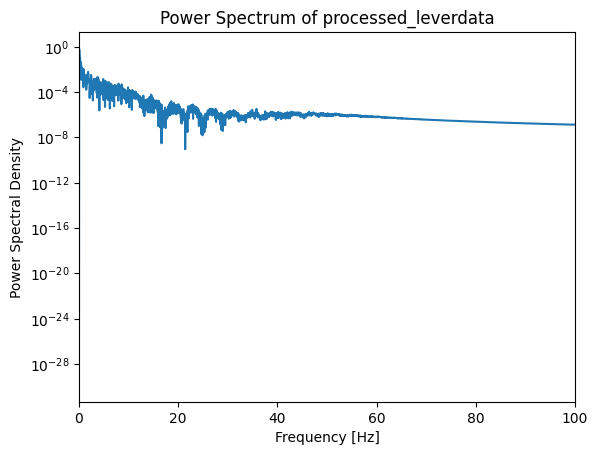

In [51]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)